In [72]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

# for todays date
from datetime import date as dt
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import datetime as dt

import matplotlib.pyplot as plt


In [22]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData

In [23]:
url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

In [24]:
req = Request(url=url, headers={'user-agent': 'my-app'})
response = urlopen(req)
html = BeautifulSoup(response, 'html')
table = html.find(id="constituents")

In [25]:
rows = table.findAll('tr')
stocks = []
for index, row in enumerate(rows):
    ticker = row.a.text
    stocks.append(ticker)

stocks = stocks[1:] # drop the column name

In [26]:
stocks[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [14]:
import pickle
with open('constituents.pkl', 'wb') as f:
    pickle.dump(stocks, f)

In [15]:
end = dt.datetime(2023, 1, 1)
start = dt.datetime(2021,1,1)

data = get_data(stocks, start, end)
# drop all columns with nan values
data = data.dropna(axis=1)

print(data.head())
# with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/data.pkl', 'wb') as f:
#     pickle.dump(data, f)

[*********************100%%**********************]  503 of 503 completed


3 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 00:00:00 -> 2023-01-01 00:00:00)')
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1672549200")



                              A    AAL        AAPL        ABBV        ABNB  \
Date                                                                         
2021-01-04 00:00:00  118.639999  15.13  129.410004  105.410004  139.149994   
2021-01-05 00:00:00  119.610001  15.43  131.009995  106.500000  148.300003   
2021-01-06 00:00:00  122.889999  15.52  126.599998  105.580002  142.770004   
2021-01-07 00:00:00  126.160004  15.38  130.919998  106.709999  151.270004   
2021-01-08 00:00:00  127.059998  15.13  132.050003  107.269997  149.770004   

                            ABT       ACGL         ACN        ADBE  \
Date                                                                 
2021-01-04 00:00:00  109.110001  34.900002  256.459991  485.339996   
2021-01-05 00:00:00  110.459999  35.040001  257.920013  485.690002   
2021-01-06 00:00:00  110.230003  36.580002  260.739990  466.309998   
2021-01-07 00:00:00  111.300003  36.240002  263.200012  477.739990   
2021-01-08 00:00:00  111.610001 

In [64]:
import pickle

#fixing error
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import datetime as dt
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

class pair_selection:
    def __init__(self, data) -> None:
        self.data = data
        self.stocks = list(data.columns)


    def kendall_tau(self):
        """"""
        out = {}
        def calculate_kendall_tau(S1, S2): 
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy-stats-kendalltau

            # calculate log returns and drop nan at start
            x = (np.log(S1) - np.log(S1.shift(1)))[1:]
            y = (np.log(S2) - np.log(S2.shift(1)))[1:]
            #print(x.head(),y.head())
            return stats.kendalltau(x,y)
        
        for r in tqdm(range(0, len(self.stocks))):
            for c in range(1, len(self.stocks)):
                if (self.stocks[r], self.stocks[c]) not in out.keys() and (self.stocks[c], self.stocks[r]) not in out.keys():
                    tau = calculate_kendall_tau(self.data[self.stocks[r]], self.data[self.stocks[c]])
                    if tau[1] <= 0.05 and (self.stocks[r] != self.stocks[c]): # if the pvalue
                        #print(self.stocks[r],self.stocks[c],'valid')
                        out[self.stocks[r], self.stocks[c]] = tau[0]
                    #print(self.stocks[r], self.stocks[c], "tau:",tau[0],"pvalue:",tau[1])
        return out
    
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData
    
def main():

    # import the ticker list (webscraped from wikipedia)
    with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/constituents.pkl', 'rb') as f:
        tickers = pickle.load(f)

    # import the data
    # end = dt.datetime(2023, 1, 1)
    # start = dt.datetime(2020,1,1)

    # data = get_data(tickers, start, end)
    # # drop all columns with nan values
    # data = data.dropna(axis=1)

    # save the data
    # with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/data.pkl', 'wb') as f:
    #     pickle.dump(data, f)

    # import the saved data to save time
    with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/data.pkl', 'rb') as f:
        data = pickle.load(f)

    selector = pair_selection(data)

    output = selector.kendall_tau()
    # print(out)
    # print(max(out))
    # print(max(out), key=out.get)
    return output

In [65]:
dct = main()

  0%|          | 0/494 [00:00<?, ?it/s]

100%|██████████| 494/494 [00:59<00:00,  8.37it/s]


In [66]:
len(dct)

120558

In [68]:
pair = max(dct, key=dct.get)

In [69]:
pair[0]

'GOOG'

In [70]:
with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/data.pkl', 'rb') as f:
    data = pickle.load(f)

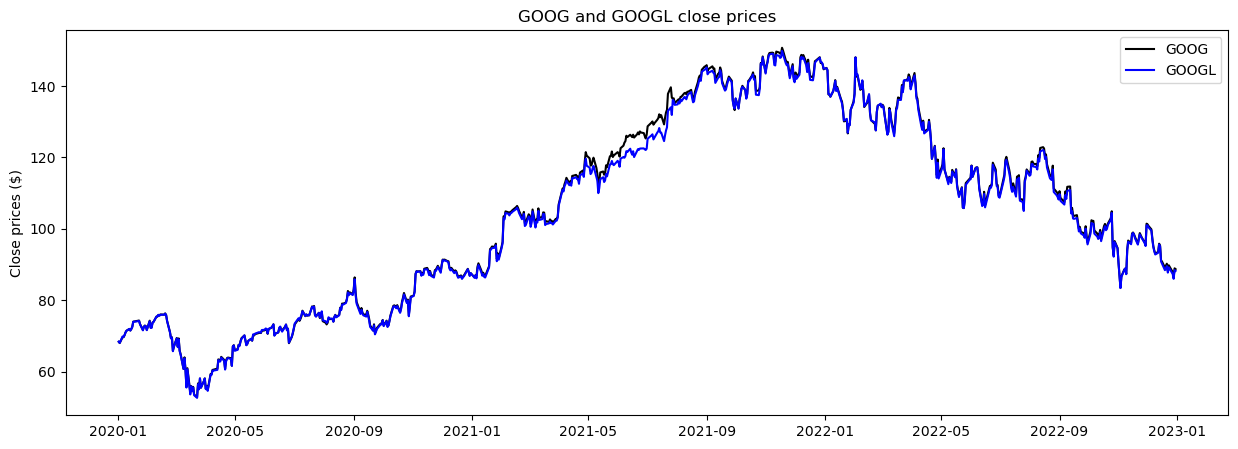

In [73]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(data.index, data[pair[0]], color='black')
plt.plot(data.index, data[pair[1]], color='blue')


plt.legend([pair[0], pair[1]])
plt.title(f'{pair[0]} and {pair[1]} close prices')
plt.ylabel('Close prices ($)')
plt.show()